# Código del proyecto final del curso SerInge

In [ ]:
import numpy as np # Calculo numérico
import matplotlib.pyplot as plt # Gráficas
import tensorflow as tf # Para deep learning
from tensorflow import keras # Para usar keras
from tensorflow.keras.utils import plot_model # Para visualizar la arquitectura de red
from tensorflow.keras.models import Sequential # Modelo secuencial, lo que hemos usado en el curso
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D # Capas necesarias
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D # Más capas
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation # Para la aumentación
from tensorflow.keras.preprocessing import image_dataset_from_directory # Para la aumentación de datos
from tensorflow.keras.layers import GlobalAveragePooling2D

from google.colab import drive # Para tomar los datos desde Google Drive
drive.mount('/content/drive') # Esta es la línea que deben escribir para montar su disco de Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Primer paso

Obtener la base de datos

In [ ]:
# Establecer el tamaño de imagen
image_size = (150,150)

In [ ]:
train_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/Pokemon_dataset", # Aquí ingresan la dirección de la carpeta de drive
    validation_split = 0.2,
    subset = 'training',
    seed = 1337,
    image_size = image_size,
    batch_size = 32
)

Found 78 files belonging to 2 classes.
Using 63 files for training.


In [ ]:
val_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/Pokemon_dataset", # Aquí ingresan la dirección de la carpeta de drive
    validation_split = 0.2,
    subset = 'validation',
    seed = 1337,
    image_size = image_size,
    batch_size = 32
)

Found 78 files belonging to 2 classes.
Using 15 files for validation.


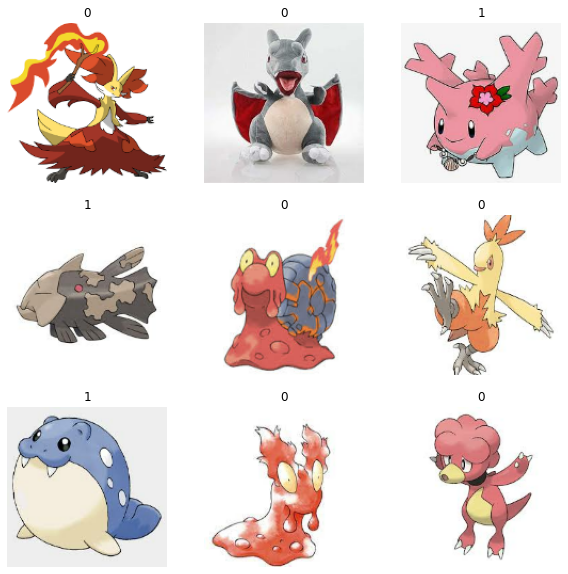

In [ ]:
### Visualizando los datos
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

## Generar arquitectura

Definiendo la red neuronal

### Aumentación de datos (opcional)

Si no quieren realizar la aumentación de datos no ejecuten estas celdas y comenten la linea número 4 de la celda donde definimos la arquitectura y escriban la siguiente línea

# x = data_augmentation(inputs)
x = inputs

In [ ]:
# Definir el tipo de aumentación de datos
data_augmentation = Sequential(
    [
     RandomFlip("horizontal"),
     RandomRotation(0.1)
    ]
)

In [ ]:
# Estas lineas indican cuánto tiempo y cuántas muestras se van a generar
# la etapa de entrenamiento del modelo
# Entre más grande el tamaño del buffer, más muestras y tiempo tardará el modelo
# en generar muestras

train_dataset = train_dataset.prefetch(buffer_size=32)
val_dataset = val_dataset.prefetch(buffer_size=32)

### La arquitectura de red

In [ ]:
def make_model(input_shape, num_classes):

  inputs = keras.Input(shape=input_shape)
  # x = data_augmentation(inputs) # Si no quieren la aumentación de datos,comenten está línea
  x = inputs # Y ejecutan esta en su lugar

  ### Construir la red
  ### Hacer la arquitectura

  # Capa de entrada
  x = Rescaling(1./255)(x)
  x = Conv2D(32, 3, strides=2, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)


  # Generar más capas convolucionales con el tamaño de filtro que indicamos
  for size in [128, 256, 512, 728]:
    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)


  x = SeparableConv2D(1024, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = GlobalAveragePooling2D()(x)

  # una condición que evalua el  numero de clases

  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes

  x = Dropout(0.5)(x)

  outputs = Dense(units, activation= activation)(x)

  return keras.Model(inputs, outputs)

### A partir de esta linea se construye el modelo

model = make_model(input_shape=image_size + (3,), num_classes=2)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 128)       4512  

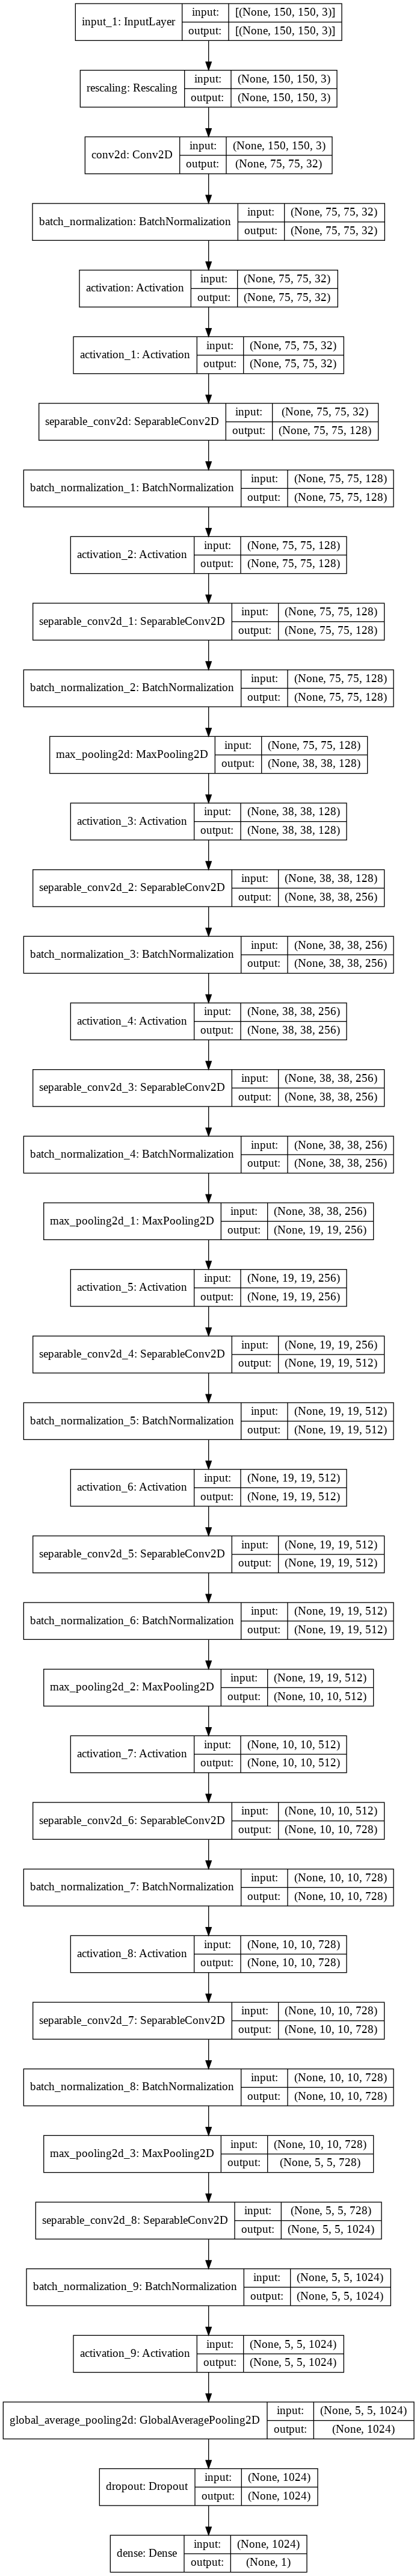

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# Establecer el numero de epocas para entrenar

epochs = 100

In [ ]:
# Compilar el modelo

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

## Cuarto paso: Entrenar el modelo

In [ ]:
hist = model.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
    batch_size = 32,
    verbose = 1,
)

Epoch 1/100
2/2 [==============================] - 9s 3s/step - loss: 0.5804 - accuracy: 0.5873 - val_loss: 0.6928 - val_accuracy: 0.5333
Epoch 2/100
2/2 [==============================] - 1s 230ms/step - loss: 0.3156 - accuracy: 0.8254 - val_loss: 0.6930 - val_accuracy: 0.5333
Epoch 3/100
2/2 [==============================] - 1s 215ms/step - loss: 0.1987 - accuracy: 0.9365 - val_loss: 0.6930 - val_accuracy: 0.5333
Epoch 4/100
2/2 [==============================] - 1s 222ms/step - loss: 0.1716 - accuracy: 0.9365 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 5/100
2/2 [==============================] - 0s 216ms/step - loss: 0.0880 - accuracy: 0.9683 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 6/100
2/2 [==============================] - 0s 220ms/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5333
Epoch 7/100
2/2 [==============================] - 0s 217ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 8/100
2/2 

## Quinto paso: Evaluar el modelo

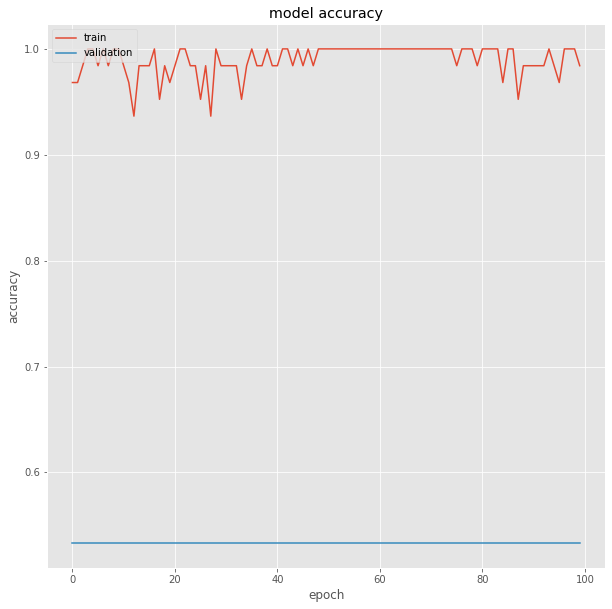

In [ ]:
# Configurar el estilo de las gráficas
plt.rcParams['figure.figsize'] = (10,10) # Tamaño XL
plt.style.use('ggplot')

### Código para graficar el accurracy del entrenamiento
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

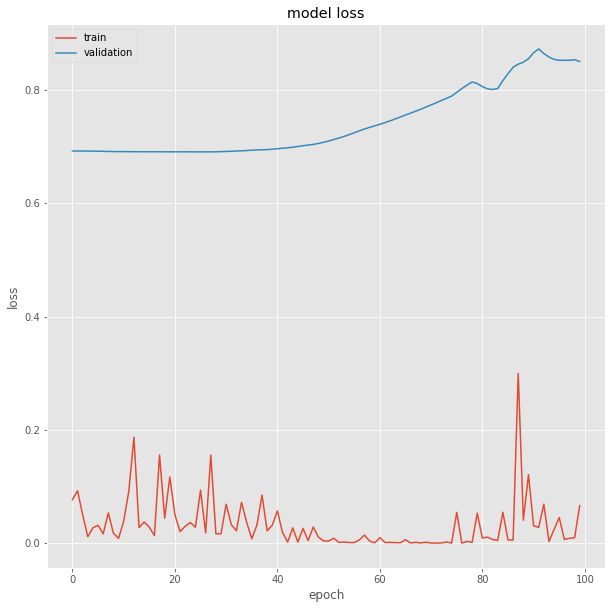

In [ ]:
### Código para graficar el accurracy del entrenamiento
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Sexto paso: Validar el modelo

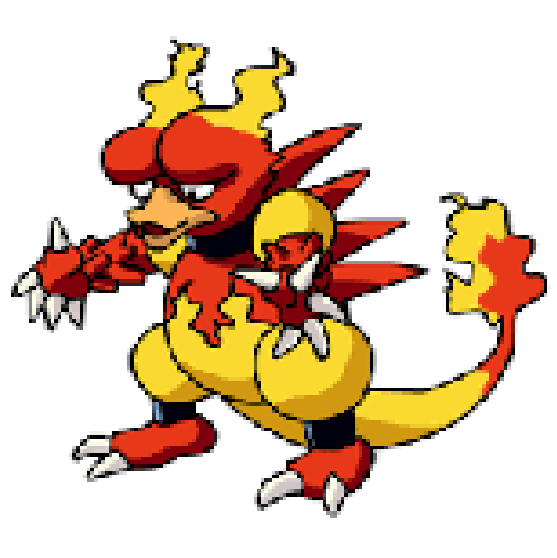

Probabilidad de ser tipo fuego: 21.23; probabilidad de ser tipo de agua: 78.77


In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Pokemon_dataset/Fire/images.png",
    target_size = image_size # tamaño de la imagen
)

plt.imshow(img)
plt.axis("off")
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)

predictions = model.predict(img_array)

score = predictions[0]

print("Probabilidad de ser tipo fuego: %.2f; probabilidad de ser tipo de agua: %.2f" % (100* (1 - score), 100*score))